In [20]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

tfd = tf.contrib.distributions

np.random.seed(0)
tf.set_random_seed(0)

CHECKPOINT_FILE = './checkpoints/vae.ckpt'

In [6]:
#
# define data model
#
mu0 = [[-4, 10, 1, 7],
       [7, -2, -5, 8],
       [1, 3, -2, 4]]
       
def generate_data(num_rows, mu):
    # latent variables: which cluster does this datapoint originate from?
    # observations:
    # x ~ N(z_i, sig)
    samples_per_cluster = num_rows // len(mu)
    samples = []
    zs = []
    for i in range(len(mu0)):
        samples.append(np.random.multivariate_normal(mu[i], np.eye(len(mu[i])), samples_per_cluster))
        zs.append(np.ones(samples_per_cluster) * i)
        
    return np.concatenate(samples), np.concatenate(zs)


In [7]:
# generate
my_data, my_clusters = generate_data(300, mu0)
my_test_data, my_test_clusters = generate_data(30, mu0)

print('Data dimensions')
print(my_data.shape)
print(my_data[:3])

print('Test data')
print(my_test_data[:3])


Data dimensions
(300, 4)
[[-2.23594765 10.40015721  1.97873798  9.2408932 ]
 [-2.13244201  9.02272212  1.95008842  6.84864279]
 [-4.10321885 10.4105985   1.14404357  8.45427351]]
Test data
[[-4.89636972  8.03726799  2.58482053  7.64796779]
 [-5.13900819  8.78559862  1.87096178  6.12202938]
 [-2.70385013 10.61645931  1.53659652  7.40469546]]


In [17]:
#
# Functions for visualizing 
#

COLORS = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

def plot_codes(ax, codes, labels=None):
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(
      axis='both', which='both', left='off', bottom='off',
      labelleft='off', labelbottom='off')


def plot_samples(ax, samples):
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')
        

def map_cluster_to_color(clusters):
    cluster_map = {}
    color_idx = 0
    colors = []
    
    for c in clusters:
        if c not in cluster_map:
            cluster_map[c] = COLORS[color_idx]
            color_idx += 1
            
        colors.append(cluster_map.get(c))
    
    return colors

In [56]:
#
# Define Network structure
# 

#
# Based on this code
# https://gist.github.com/danijar/1cb4d81fed37fd06ef60d08c1181f557
#

NUM_HIDDEN_UNITS = 200
BOTTLENECK_DIMS = 2
INPUT_DIMS = 4


# number of units in hidden encoder layer
# NUM_HIDDEN_UNITS = 4
# BOTTLENECK_DIMS = 2
# INPUT_DIMS = 4


def make_prior(code_size):
    """
    p(z) 
    Information bottleneck 
    """
    mean, stddev = tf.zeros([code_size]), tf.ones([code_size])
    return tfd.MultivariateNormalDiag(mean, stddev)


def make_encoder(input_data, code_size):
    """
    q(z | x)
    Encoder network
    """

    # images = tf.layers.flatten(images)  
    with tf.name_scope('encoder'):
        input_data_flat = tf.layers.flatten(input_data)
        hidden = tf.layers.dense(input_data_flat, NUM_HIDDEN_UNITS, tf.nn.relu, name='hidden')

        # no activation on mean layer ?
        mean = tf.layers.dense(hidden, code_size, name='mean')
        # softplus = log(exp(features) + 1)
        stddev = tf.layers.dense(hidden, code_size, tf.nn.softplus, name='stdev')
        encoded = tfd.MultivariateNormalDiag(mean, stddev)
        
#         print('----- Encoder ------')
#         print('NUM_HIDDEN_UNITS:', NUM_HIDDEN_UNITS)
#         print('input_data_flat:', input_data_flat.get_shape())
#         print('hidden:', hidden.get_shape())
#         print('mean:', mean.get_shape())
#         print('stddev:', stddev.get_shape())        
#         print('encoded:', type(encoded))                
#         print('----- Encoder ------\n\n')
        return encoded


def make_decoder(code, data_shape):
    """
    p(x | z)
    Decoder network
    """
    with tf.name_scope('decoder'):
        hidden = tf.layers.dense(code, NUM_HIDDEN_UNITS, tf.nn.relu, name='hidden')

#         mean = tf.layers.dense(hidden, np.prod(data_shape), name='mean')
#         # softplus = log(exp(features) + 1)
#         stddev = tf.layers.dense(hidden, np.prod(data_shape), tf.nn.softplus, name='stdev')
#         return tfd.MultivariateNormalDiag(mean, stddev)
                
        logit_full = tf.layers.dense(hidden, np.prod(data_shape))
        logit = tf.reshape(logit_full, [-1] + data_shape)
#         print('NUM_HIDDEN_UNITS:', NUM_HIDDEN_UNITS)
#         print('code:', code)
#         print('hidden:', hidden.get_shape())
#         print('data shape:', data_shape)
#         print("logit full shape:", logit_full.get_shape())
#         print("logit shape:", logit.get_shape())
        #TODO change this to be normally distributed?
        return tfd.Independent(tfd.Bernoulli(logit), len(data_shape))

In [57]:
tf.reset_default_graph()


# data = tf.placeholder(tf.float32, [None, 4])
#
# MNIST images
data = tf.placeholder(tf.float32, [None, 28, 28])

# facilitates variable sharing
# templates will create variables the first time, then reuse them thereafter
# https://www.tensorflow.org/api_docs/python/tf/make_template
make_encoder_template = tf.make_template('encoder', make_encoder)
make_decoder_template = tf.make_template('decoder', make_decoder)


# construct the network
prior = make_prior(code_size=BOTTLENECK_DIMS)
posterior = make_encoder_template(data, code_size=BOTTLENECK_DIMS)
code = posterior.sample()

# Define the loss
likelihood = make_decoder_template(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)

elbo = tf.reduce_mean(likelihood - divergence)

# setup optimizer:
# we actually want to maximize this since its a lower bound on the 
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)

samples = make_decoder_template(prior.sample(10), [28, 28]).mean()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -544.9329
============ test codes [0]
Epoch 1 elbo -178.0434
============ test codes [1]
Epoch 2 elbo -169.38397
============ test codes [2]
Epoch 3 elbo -166.55208
============ test codes [3]
Epoch 4 elbo -164.41455
============ test codes [4]
Epoch 5 elbo -163.04892
============ test codes [5]
Epoch 6 elbo -161.9298
============ test codes [6]
Epoch 7 elbo -160.57083
============ test codes [7]
Epoch 8 elbo -159.72603
============ test codes [8]
Epoch 9 elbo -158.70271
============ test codes [9]
Epoch 10 elbo -158.1092
============ test codes [10]
Epoch 11 elbo -157.52255
============ test codes [11]
Epoch 12 elbo -157.06152
============ test codes [12]
Epoch 13

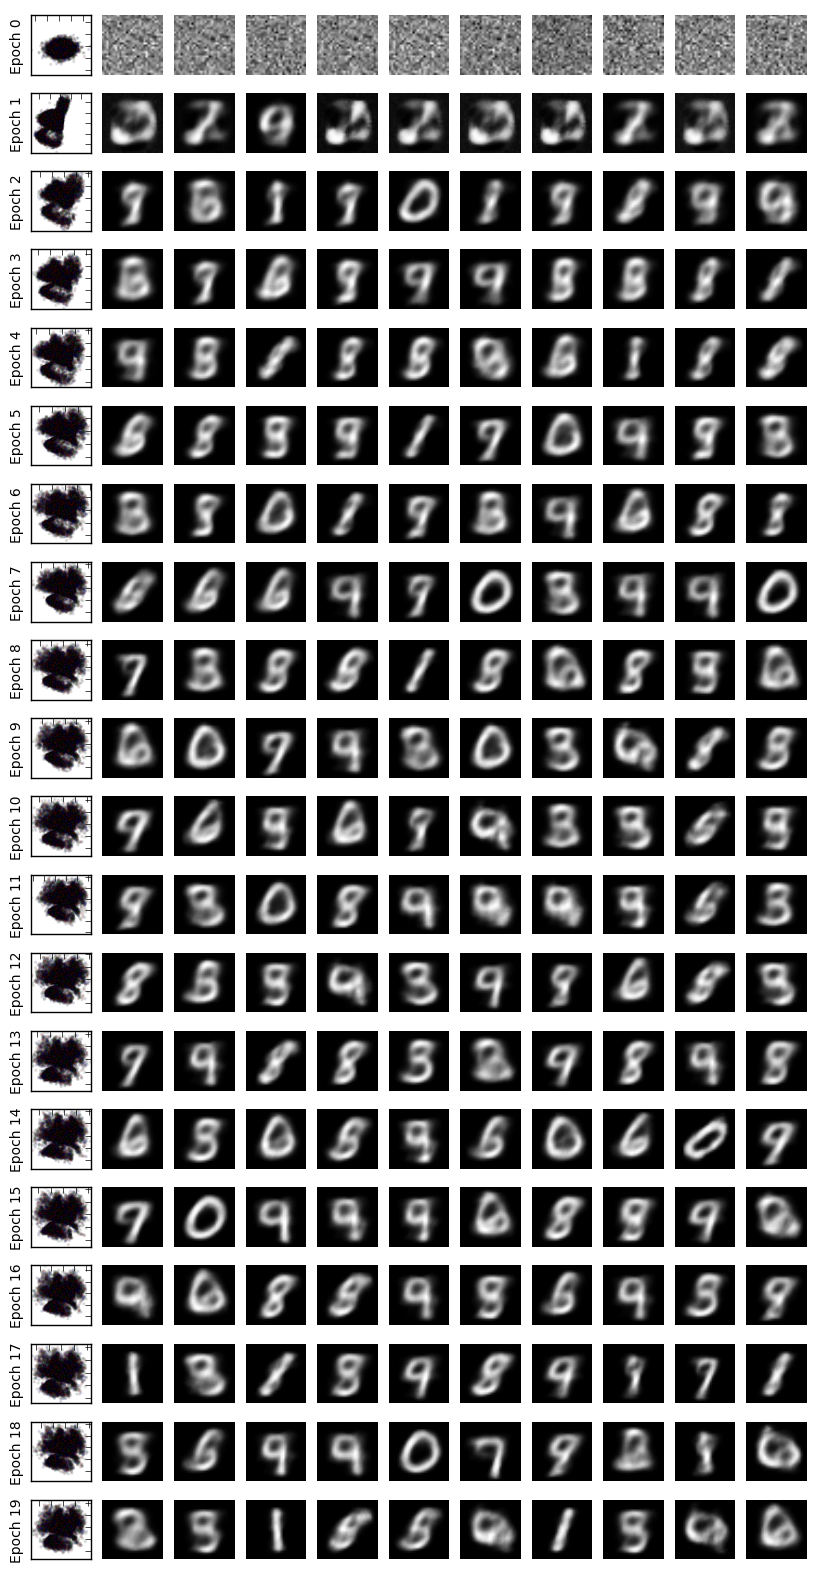

In [59]:
#
#  MODEL TRAINING
#
fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
colors = map_cluster_to_color(my_test_clusters)

# Add ops to save and restore all the variables.
# saver = tf.train.CheckpointSaverHook(CHECKPOINT_FILE, save_steps=10)
# summary = tf.train.SummarySaverHook(save_steps=10, 
#                                     output_dir='./summaries/',
#                                     scaffold=tf.train.Scaffold(summary_op=tf.summary.merge_all()))

mnist = input_data.read_data_sets('MNIST_data/')
with tf.train.MonitoredSession() as sess:

    for epoch in range(20):
        
        # for use with MNIST images
        feed = {data: mnist.test.images.reshape([-1, 28, 28])}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        
# #         test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], 
# #                                                       feed_dict={data: my_test_data.reshape([-1, 4])})
        
        print('Epoch', epoch, 'elbo', test_elbo)
        print('============ test codes [{}]'.format(epoch))
        
#         for code_, clust in zip(test_codes, my_test_clusters):
#             print('Code:  ', code_)
#             print('Cluster: ', clust)
#         print('-----\n')
        
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_codes(ax[epoch, 0], test_codes, colors)
        plot_samples(ax[epoch, 1:], test_samples)

        # TODO: could test with minibatching
#         for row in my_data:
        for _ in range(600):
            # for use with MNIST images
            feed = {data: mnist.train.next_batch(100)[0].reshape([-1, 28, 28])}
            sess.run(optimize, feed)
#             sess.run(optimize, feed_dict={data: row.reshape([1, 4])})
        
plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')


In [ ]:
#
# quicker testing after we've trained by restoring the model!
#

fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))
colors = map_cluster_to_color(my_test_clusters)

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

with tf.train.MonitoredSession() as sess:
    
    saver.restore(sess, CHECKPOINT_FILE)
    for epoch in range(20):
        
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], 
                                                      feed_dict={data: my_test_data.reshape([-1, 4])})
        
        print('Epoch', epoch, 'elbo', test_elbo)
        print('test codes')
        print(test_codes)
        print('\n')
        
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_codes(ax[epoch, 0], test_codes, colors)
        plot_samples(ax[epoch, 1:], test_samples)
